# This cell has two classes:
1. `EnvChannel`: Defines the environment
2. `ControlAgent`: Defines the control agent

# Parameters:
1. ```alpha```: Learning rate of agent
2. `gamma`: Discount factor
3. `epsilon`: for epsilon-greedy policy
4. `num_states`: Number of states in system, currently three(Good, Medium, Bad)
5. `d1`: Delay threshold for Good state and medium state
6. `d2`: Delay threshold for Medium and bad state

# Return:
1. ```action (int)```: -1: Decrease Resolution; 0: No change; 1: Increase Resolution
2. `state (int)`: 0: Bad; 1: Medium; 2: Good


# Arguments:
1. `state_list`: List of integer states. 
2. `avg_confidence`: (Float) Average confidence 
    
# Sample use:

Initialize ControlAgent class:
```
agent = ControlAgent(resolution_list=[100,200,300], d1=0.00103,d2=0.00161)
```
To train and get optimal actions
```
action = agent.get_signal(delay_list = [.5,.6], curr_resolution=200, error_score=.5)
```

To get random actions:
```
agent = ControlAgent(resolution_list=[100,200,300], d1=0.00103,d2=0.00161, random_actions=True)
```

# To Do:
1. ~~Instead of taking state_list directly, estimate the states indirectly from packet delay.~~ **Done**
2. ~~Update the function get_delay_factor.~~ **Done** 


In [ ]:
import numpy as np
import pickle
import sys, os
import datetime


# Define an environment channel class for reinforcement learning.
class EnvChannel:
    def __init__(self, resolution_list, d1=.01, d2=.02):
        # Initialize the environment with given parameters.
        self.num_delay_bins = 3  # Number of delay bins (states)
        self.num_resolutions = len(resolution_list)  # Number of resolutions
        self.resolution_dict = {resolution: i for i, resolution in enumerate(resolution_list)}  # Map resolutions to indices
        
        # Calculate the total number of states, initialize current and previous states, and other attributes.
        self.num_states = self.num_delay_bins * self.num_resolutions
        self.curr_state = (0, 0) # delay, resolution
        self.prev_state = (0, 0)
        self.reward = 0
        self.action = 0
        self.num_actions = 3  # Number of possible actions
        self.valid_actions = [0, 1, 2]  # Valid actions: Reduce, No change, Increase
        self.d1 = d1  # Threshold for "good" delay state
        self.d2 = d2  # Threshold for "medium" delay state
        self.avg_delay = 0
        self.curr_resolution = 0
        self.error_score = 0

    def sample_action(self):
        # Randomly sample an action from the valid actions.
        return np.random.choice(self.valid_actions)

    def get_reward(self):
        # Calculate the reward based on the current state and error score.
        return 0.5 * self.resolution_state / (self.delay_state + 1) + 0.5 * self.error_score

    def step(self, action):
        # Perform a step in the environment based on the chosen action.
        self.action = action
        self.reward = self.get_reward()
        return self.reward, self.estimate_state()

    def estimate_state(self):
        # Estimate the current state based on resolution and average delay.
        self.resolution_state = self.resolution_dict[self.curr_resolution]
        if self.avg_delay <= self.d1:
            self.delay_state = 0  # Good state
        elif self.avg_delay <= self.d2:
            self.delay_state = 1  # Medium state
        else:
            self.delay_state = 2  # Bad state
        self.curr_state = (self.delay_state, self.resolution_state)
        return self.curr_state

    def reset(self):
        # Reset the environment to its initial state.
        self.__init__(num_states=self.num_states)
        return self.curr_state

# Define a control agent class for reinforcement learning.
class ControlAgent:
    def __init__(self, resolution_list, d1, d2, alpha=0.1, gamma=0.1, epsilon=0.3, random_actions=False):
        # Initialize the control agent with various parameters.
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration probability
        self.env = EnvChannel(resolution_list, d1, d2)  # Create an environment instance
        self.q_table = np.zeros([self.env.num_delay_bins, self.env.num_resolutions, self.env.num_actions])  # Q-table for storing action values
        self.all_epochs = []  # List to record training epochs
        self.action_record = []  # List to record taken actions
        self.state_record = []  # List to record observed states
        self.penalties = []  # List to record penalties (rewards)
        self.iteration_i = 0  # Iteration counter
        self.prev_state = None  # Previous state
        self.prev_avg_delay = 0  # Previous average delay
        self.random_actions = random_actions  # Flag for random actions
        self.path = "Channel_Data"
        self.f_name = "/Data_"+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")+".pkl"
        self.create_directory()
        
        
    def create_directory(self):
        # check if channel_data directory exists
        if not os.path.exists(self.path):
            os.mkdir(self.path)

    def map_action(self, state):
        # Map an action to a change in delay state.
        if state == 0:
            return -1  # Reduce delay
        if state == 1:
            return 0  # No change in delay
        if state == 2:
            return 1  # Increase delay

    def get_signal(self, delay_list, curr_resolution, error_score):
        # Receive input signals and update the agent's knowledge.
        self.env.avg_delay = np.average(delay_list)  # Update average delay
        self.env.curr_resolution = curr_resolution  # Update current resolution
        self.env.error_score = np.abs(error_score) / 100.0  # Update error score (normalized)
        
        self.iteration_i += 1  # Increment iteration counter
        
        # Decay alpha and epsilon values over time.
        if np.mod(self.iteration_i + 2, 10) == 0:
            self.alpha = self.alpha * 0.95
            self.epsilon = self.epsilon * 0.95

        if self.iteration_i == 1:
            state = self.env.estimate_state()
            action = self.env.sample_action()
            reward = 0
        else:
            reward, state = self.env.step(self.prev_action)
            self.state_record.append(self.env.curr_state)

            if not self.random_actions:
                old_qvalue = self.q_table[self.prev_state[0], self.prev_state[1], self.prev_action]
                next_max = np.max(self.q_table[state[0], state[1], :])

                # Update Q-value using Q-learning equation.
                new_qvalue = (1 - self.alpha) * old_qvalue + self.alpha * (reward + self.gamma * next_max)
                self.q_table[self.prev_state[0], self.prev_state[1], self.prev_action] = new_qvalue
                self.penalties.append(reward)
                self.action_record.append(self.prev_action)

                if np.random.uniform(0, 1) < self.epsilon:
                    action = self.env.sample_action()  # Explore action space
                else:
                    # Exploit learned values to select an action.
                    action = np.argmax(self.q_table[state[0], state[1], :])
            else:
                action = self.env.sample_action()  # Explore action space

        self.prev_state = state  # Update previous state
        self.prev_action = action  # Update previous action
        
        if self.iteration_i%20 == 0: 
            with open(path+f_name,'wb') as fp:
                pickle.dump([self.q_table, self.alpha, self.epsilon])
        return self.map_action(action), action, state, reward  # Return mapped action, action taken, current state, and reward

### For Testing

In [ ]:
agent = ControlAgent(resolution_list=[300,500,700], d1=0.00103,d2=0.00161)
avg_delay = []
rerun_list = []
for i in range(len_df):
    avg_delay.append(data_df["Delays"][i])
    age_deviation.append(data_df["Age Deviation"][i])
        
    if i != 0:
        if data_df["Loop Packet Count"][i] == 1  or i== len_df-1:
            reso = data_df["Resolution"][i-1]
            action = agent.get_signal(delay_list = avg_delay, curr_resolution=reso, error_score=.5)
            avg_delay = []
            rerun_list.append([action, reso])
            
rerun_list    

In [ ]:


import numpy as np
import pandas as pd
# xl_file=pd.ExcelFile("Downloads/Results_06_09_23.xlsx")
f_name = '../../../../../../Downloads/Results_18_09_23.xlsx'
# data_df = pd.read_excel(f_name, sheet_name=1)

len_df = len(data_df)
column_names = ["Loop", "Action", "Control_State", "Reward", "Resolution", "Avg_delay", "HMM_State_Most", 
                "HMM_State_Proportion", "Age_deviation"]
summary_df = pd.DataFrame(columns=column_names)

loop_count = 0
hmm_state_cnt = np.zeros([4,])
avg_delay = []
age_deviation = []


for i in range(len_df):
    if i!=0 and (data_df["Loop Packet Count"][i-1] > data_df["Loop Packet Count"][i] or i==len_df-1):
        action = data_df["Action"][i-1]
        control_state = data_df["Channel State"][i-1]
        reward = data_df["Reward"][i-1]
        reso = data_df["Resolution"][i-1]
        hmm_most = np.argmax(hmm_state_cnt)
        hmm_prop = np.max(hmm_state_cnt)/np.sum(hmm_state_cnt)
        
        #add to summary df
        summary_df.loc[loop_count] = [loop_count, action, control_state, reward, reso, np.average(avg_delay), 
                                  hmm_most, hmm_prop, np.average(age_deviation)]
        
        #reset values
        hmm_state_cnt = np.zeros([4,])
        avg_delay = []
        age_deviation = []
        loop_count += 1
        print(loop_count)
    
    avg_delay.append(data_df["Delays"][i])
    age_deviation.append(data_df["Age Deviation"][i])
    hmm_state_cnt[data_df["State Array"][i]] += 1
    
        
summary_df.to_csv("Summary.csv")

## Plot results

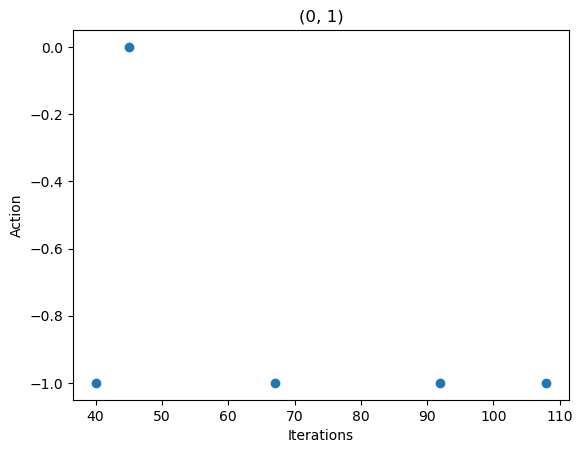

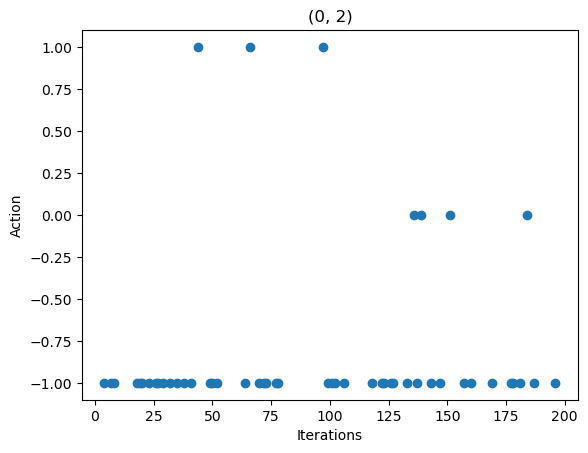

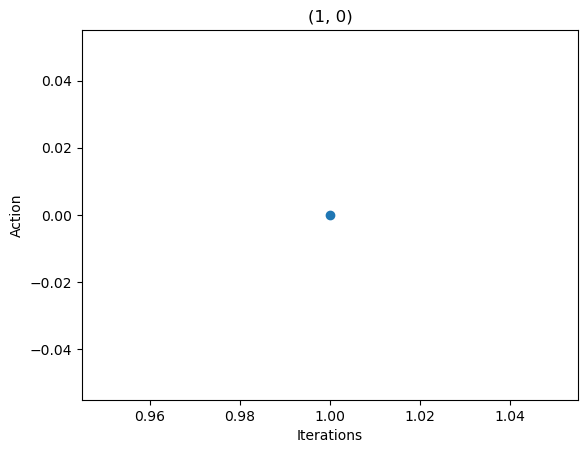

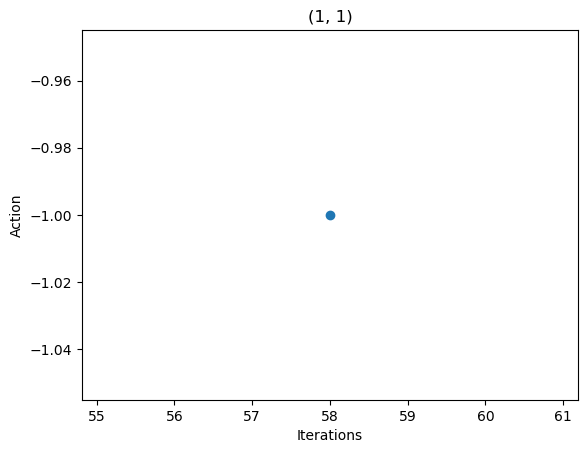

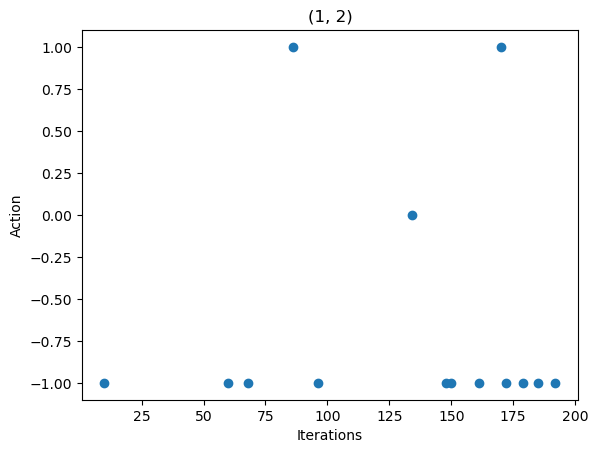

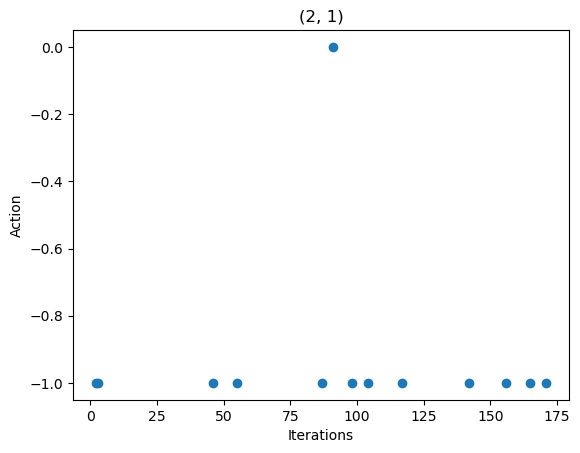

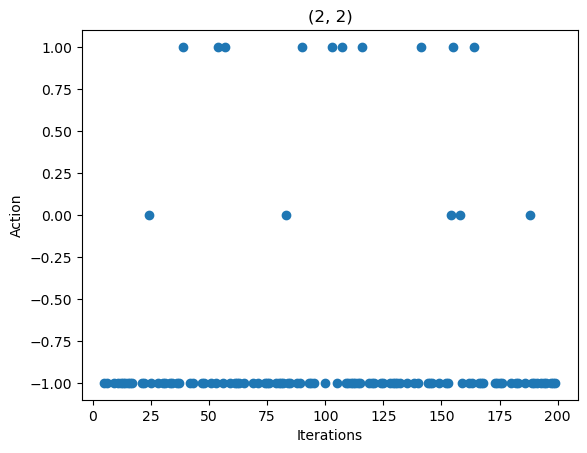

In [62]:
import matplotlib.pyplot as plt

states = ["(0, 1)", "(0, 2)", "(1, 0)", "(1, 1)", "(1, 2)", "(2, 1)", "(2, 2)"]
for state in states:
    x,y = [], []
    for i in range(len(summary_df)):
        if state == summary_df['Control_State'][i]:
            x.append(summary_df['Loop'][i])
            y.append(summary_df['Action'][i])
    plt.scatter(x, y)
    plt.title(state)
    plt.xlabel("Iterations")
    plt.ylabel("Action")
    plt.show()